# Выбор локации для скважины

## Цель исследования и план работ

Заказчик - добывающая компании.  

**Задача**  

Нужно решить, где бурить новую скважину. Наи предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль и проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Условия задачи**  

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

**Описание данных**  

Нам предоставлены данные геологоразведки трёх регионов, которые находятся в трёх разных файлах.

*Признаки:*  

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);  

*Целевой признак:*  

- product — объём запасов в скважине (тыс. баррелей).

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

**План работы**  

Данная работа состоит из следующих этапов:  

1) Загрузка и подготовка данных:  
- загрузим и подготовим данные;  
- поясним порядок действий.  

2) Обучение и проверка модели для каждого региона:  
- разобьём данные на обучающую и валидационную выборки в соотношении 75:25;  
- обучим модели и сделаем предсказания на валидационной выборке;  
- сохраним предсказания и правильные ответы на валидационной выборке;  
- напечатаем на экране средний запас предсказанного сырья и RMSE модели;  
- проанализируем результаты.  

3) Подготовка к расчёту прибыли:  
- все ключевые значения для расчётов сохраним в отдельных переменных;  
- рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе;  
- напишем выводы по этапу подготовки расчёта прибыли.    

4) Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:  
- выберем скважины с максимальными значениями предсказаний;  
- просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям;  
- рассчитаем прибыль для полученного объёма сырья.  

5) Посчитаем риски и прибыль для каждого региона:  
- применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли;  
- найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль;  
- напишем выводы: предложим регион для разработки скважин и обоснуем выбор;  

6) Итоги исследования и общий вывод.  

## Загрузка и подготовка данных

### Обзор данных

Импортируем все необходимые библиотеки для проведения исследования.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats as st
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Загрузим данные геологоразведки трёх регионов и выведем на экран первые пять строк каждого датасета.

In [2]:
gd_0 = pd.read_csv('geo_data_0.csv')
gd_1 = pd.read_csv('geo_data_1.csv')
gd_2 = pd.read_csv('geo_data_2.csv')

In [3]:
def show_head(df_1, df_2, df_3):
    display(df_1.head(), df_2.head(), df_3.head())

show_head(gd_0, gd_1, gd_2)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Выведем на экран общую информацию о датафреймах.

In [4]:
print(gd_0.info())
print()
print(gd_1.info())
print()
print(gd_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column

#### Выводы

Из общих данных можно сделать следующие выводы:  
1) в 3-ёх таблицах по 100000 строк и 5 столбцов;  
2) пропуски данных во всех столбцах отстуствуют;  
3) типы данных во всех столбцах корректны;  
4) признак `id` - уникальный идентификатор скважины, не является важным, его следует удалить.

### Предобработка данных

Для данных не требуется обработка пропусков, обработка дубликатов.  
Проверим наличие аномальных значений и взаимосвязь данных.

#### Обработка аномальных значений

Рассмотрим характерные значения числовых наборов данных в датасетаx.

In [5]:
display(gd_0.describe())
display(gd_1.describe())
display(gd_2.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


**Вывод:** для всех признаков медиана близка к среднему, что говорит об отсутствии выбросов и аномалий.

Чтобы убедиться, посмотрим гисторграмму признаков датасета для третьего региона.

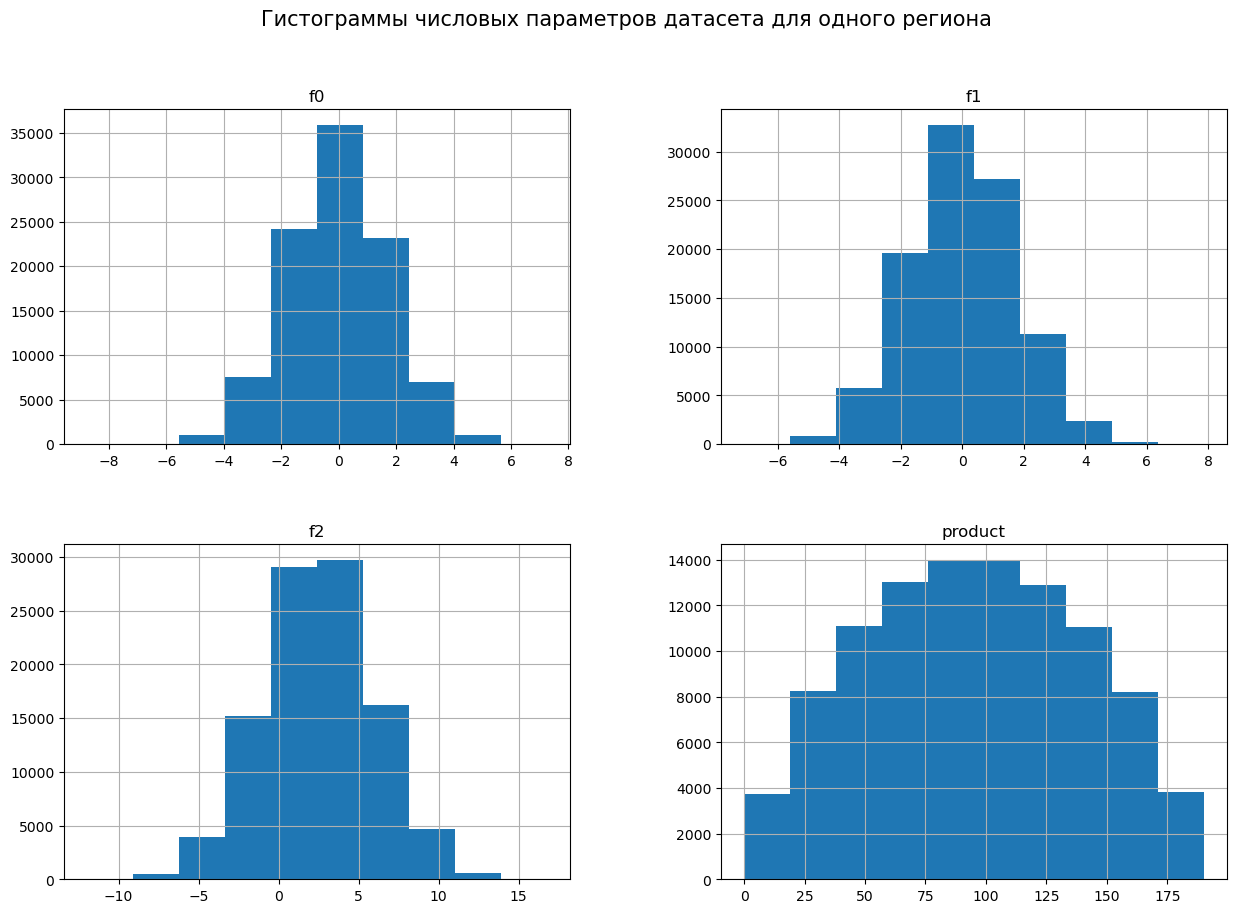

In [6]:
gd_2.hist(figsize=(15, 10))
plt.suptitle("Гистограммы числовых параметров датасета для одного региона", fontsize=15);

#### Изучение взаимосвязи данных

Рассмотрим корреляцию между признаками для всех датафреймов, чтобу исключить мультиколлениарность.

1) Рассмотрим коэффициент корреляции Пирсона и диаграммы рассеяния для данных первого региона.

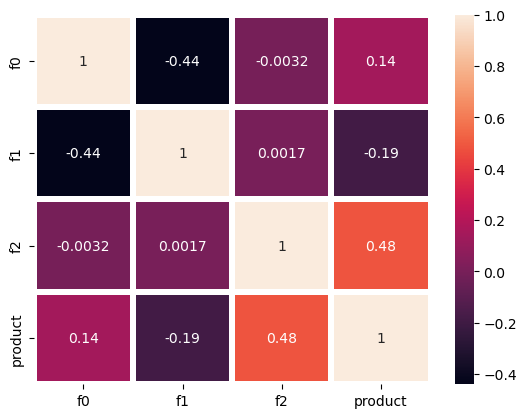

In [7]:
sns.heatmap(gd_0.corr(), annot=True, linewidths=3, linecolor='white');

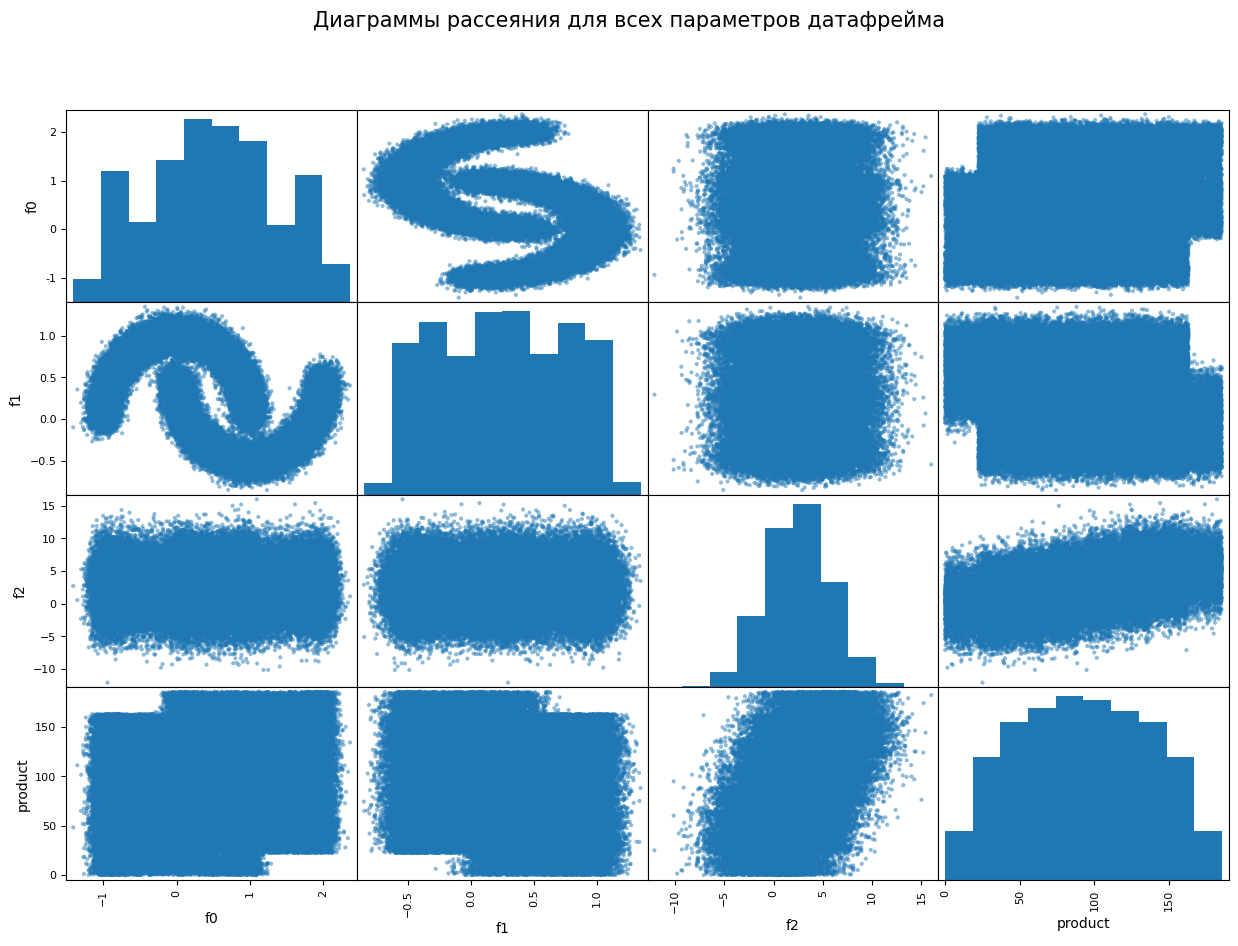

In [8]:
pd.plotting.scatter_matrix(gd_0, figsize=(15, 10))
plt.suptitle('Диаграммы рассеяния для всех параметров датафрейма', fontsize=15);

**Вывод:**  
- взаимосвязь между параметрами f0 и f1 отсутствует либо имеет очень сложный нелинейный характер;  
- коэффициент Пирсона между между величинами f2 и f0, f2 и f1 практически равен 0, то есть с уведичением f0 и f1 величина f2 остаётся прежней, взаимосвязи между признаками нет;  
- взаимосвязь между величинами product и f0 / f1 очень слабая;  
- признаки product и f2 имеют слабую линейную положительную взаимосвязь, коэффициент Пирсона 0.48, но взаимосвязь между признаком и целевым признаком допустима.

2) Рассмотрим коэффициент корреляции Пирсона и диаграммы рассеяния для данных второго региона.

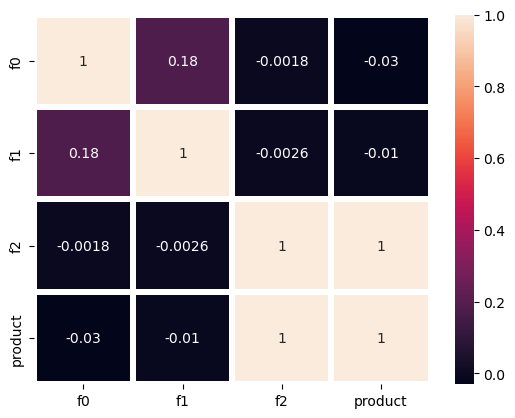

In [9]:
sns.heatmap(gd_1.corr(), annot=True, linewidths=3, linecolor='white');

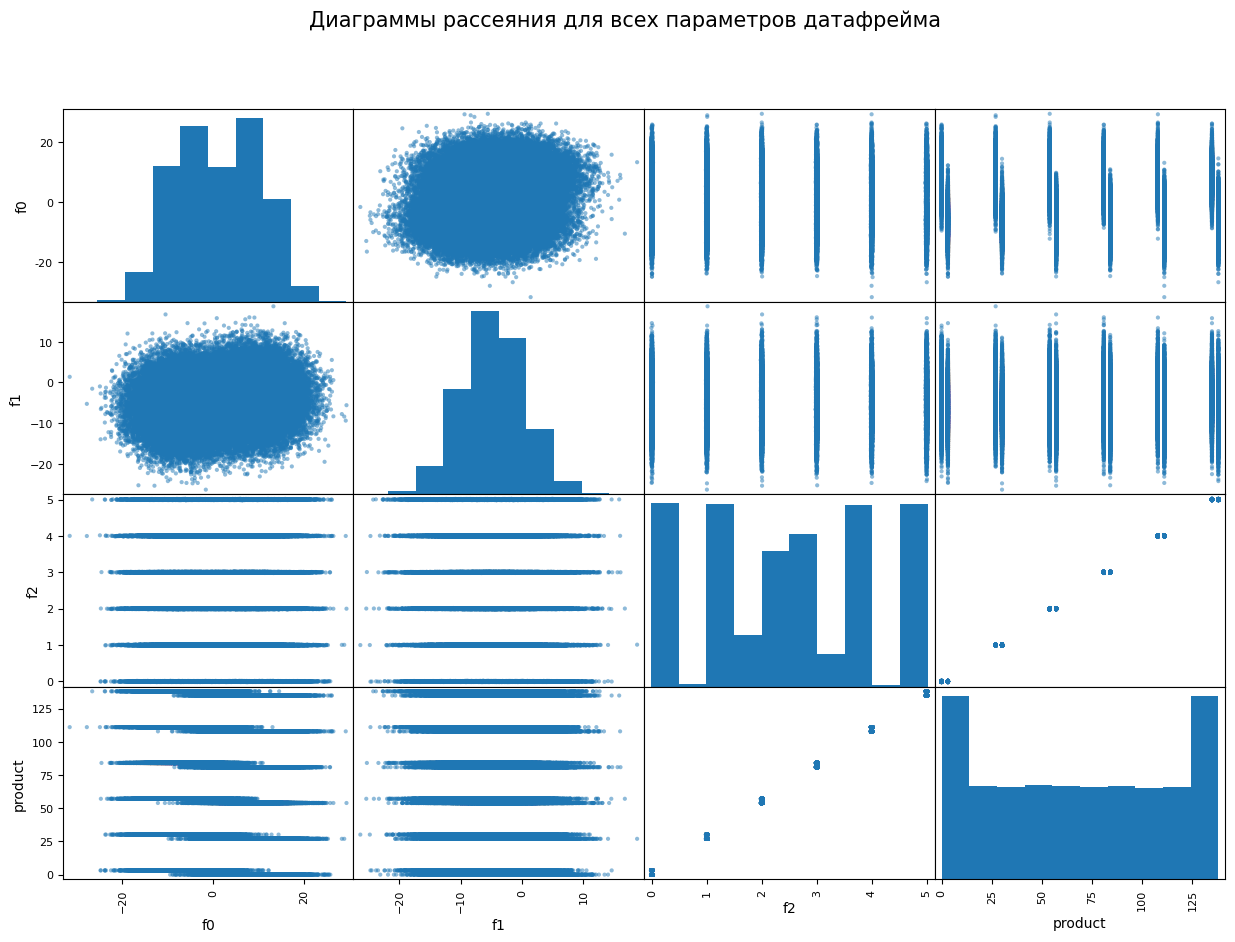

In [10]:
pd.plotting.scatter_matrix(gd_1, figsize=(15, 10))
plt.suptitle('Диаграммы рассеяния для всех параметров датафрейма', fontsize=15);

**Вывод:**  
- взаимосвязи между параметрами f0, f1, f2 нет;  
- в данном регоине имеется прямая зависимость продукта от признака f2.

3) Рассмотрим коэффициент корреляции Пирсона и диаграммы рассеяния для данных третьего региона.

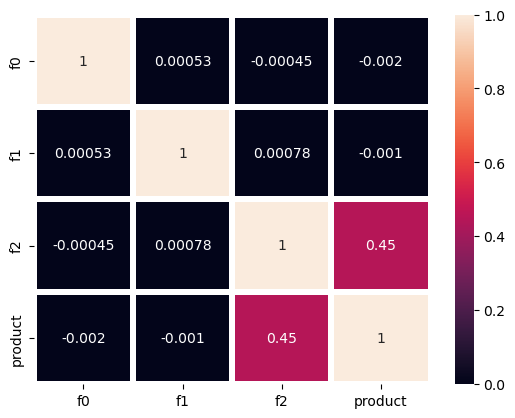

In [11]:
sns.heatmap(gd_2.corr(), annot=True, linewidths=3, linecolor='white');

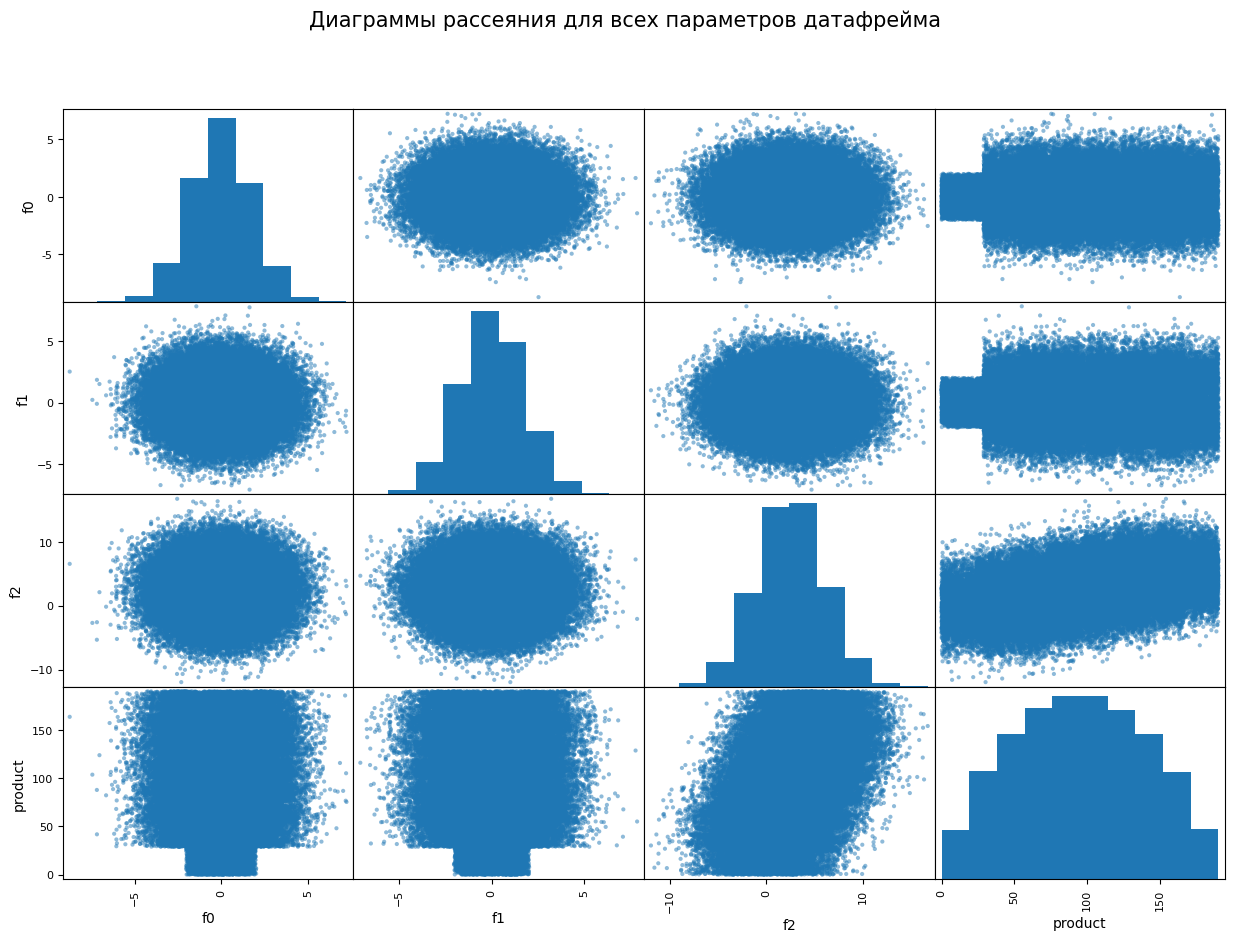

In [12]:
pd.plotting.scatter_matrix(gd_2, figsize=(15, 10))
plt.suptitle('Диаграммы рассеяния для всех параметров датафрейма', fontsize=15);

**Вывод:**  
- взаимосвязи между признаками f0, f1, f2 нет;  
- имеется слабая линейная зависимость продукта от признака f2.

**Общий вывод по взаимосвязи данных:**
1) для все регионов взаимосвязь признаков отсутствует, мультиколлинеарности нет;  
2) для всех регинов есть линейная зависимость объема запасов нефти от признака f2, а для второго регион имеется **прямая линейная зависимость** объема нефти от признака f2 (коэффициент корреляции Пирсона =1)

### Подготовка признаков

#### Удаление незначимых признаков

Признак `id` не несёт никакой пользы для обучения модели и решения задачи регрессии. Удалим этот столбец.

In [13]:
gd_0 = gd_0.drop('id', axis=1)
gd_1 = gd_1.drop('id', axis=1)
gd_2 = gd_2.drop('id', axis=1)

#### Масштабирование признаков

Разделим выборки на признаки и целевой признак.

In [14]:
def split_features_target(df):
    return df.drop('product', axis=1), df['product']

features_gd_0, target_gd_0 = split_features_target(gd_0)
features_gd_1, target_gd_1 = split_features_target(gd_1)
features_gd_2, target_gd_2 = split_features_target(gd_2)

Разделим выборки на обучающую и валидационную выборки в соотношении 75%, 25% соответственно.

In [15]:
def split_train_valid(features, target):
    return train_test_split(features, target, test_size=0.25, random_state=12345)

features_gd_0_train, features_gd_0_valid, target_gd_0_train, target_gd_0_valid = split_train_valid(features_gd_0, target_gd_0)
features_gd_1_train, features_gd_1_valid, target_gd_1_train, target_gd_1_valid = split_train_valid(features_gd_1, target_gd_1)
features_gd_2_train, features_gd_2_valid, target_gd_2_train, target_gd_2_valid = split_train_valid(features_gd_2, target_gd_2)

In [16]:
#построим таблицу с размерностями обучающей и валидационной выборок и долями от исходных данных
pd.DataFrame({'Размерность выборки': [features_gd_0_train.shape, features_gd_0_valid.shape],
             'Доля от исходных данных': [round(len(features_gd_0_train.index) / len(features_gd_0.index), 2), 
                                         round(len(features_gd_0_valid.index) / len(features_gd_0.index), 2)]}, 
             index=['features_gd_0_train', 'features_gd_0_valid'])

,Размерность выборки,Доля от исходных данных
features_gd_0_train,"(75000, 3)",0.75
features_gd_0_valid,"(25000, 3)",0.25


Проведем масштабирование признаков методом стандартизации данных.

In [17]:
# создадим список численных признаков для масштабирования
numeric = ['f0', 'f1', 'f2']

def scaling(features_train, features_valid):
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train = scaler.transform(features_train)
    features_valid = scaler.transform(features_valid)
    return features_train, features_valid

features_gd_0_train[numeric], features_gd_0_valid[numeric] = scaling(features_gd_0_train[numeric], features_gd_0_valid[numeric])
features_gd_1_train[numeric], features_gd_1_valid[numeric] = scaling(features_gd_1_train[numeric], features_gd_1_valid[numeric])
features_gd_2_train[numeric], features_gd_2_valid[numeric] = scaling(features_gd_2_train[numeric], features_gd_2_valid[numeric])

In [18]:
features_gd_0_train

,f0,f1,f2
27212,-0.544828,1.390264,-0.094959
7866,1.455912,-0.480422,1.209567
62041,0.260460,0.825069,-0.204865
70185,-1.837105,0.010321,-0.147634
82230,-1.299243,0.987558,1.273181
...,...,...,...
4094,1.567114,-1.087243,-0.272211
85412,-1.904207,-0.525360,1.327530
2177,0.418949,-1.296788,-0.196407
77285,0.400077,-1.466874,-0.445317


### Вывод

Мы провели загрузку и подготовку данных геологоразведки трёх регионов, проверили данные на пропуски и аномальные значения, посмотрели взаимосвязи данных, удалили незначимый для решения задачи регрессии признак `id`, разделили выборки на обучающую и валидационную, провели масштабирование признаков.

## Обучение и проверка модели

Обучим модель линейной регрессии на данных геологоразведки трёх регионов и сделаем предсказания на валидационной выборке.
Сохраним предсказания и правильные ответы на валидационной выборке. Напечатаем на экране средний запас предсказанного сырья и RMSE модели для каждого региона.

In [19]:
# напишем функцию, которая обучает модель на тренировочной выборке, делает предсказания на валидационной выборке и 
# возвращает предсказания и метрику RMSE
def make_predictions(features_train, target_train, features_valid, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    rmse = mean_squared_error(target_valid, predictions_valid) ** 0.5
    return pd.Series(predictions_valid, index=features_valid.index), rmse

predictions_gd_0_valid, gd_0_rmse = make_predictions(features_gd_0_train, target_gd_0_train, features_gd_0_valid, target_gd_0_valid)
predictions_gd_1_valid, gd_1_rmse = make_predictions(features_gd_1_train, target_gd_1_train, features_gd_1_valid, target_gd_1_valid)
predictions_gd_2_valid, gd_2_rmse = make_predictions(features_gd_2_train, target_gd_2_train, features_gd_2_valid, target_gd_2_valid)

pd.DataFrame({'Истинное значение среднего запаса сырья для региона': [round(gd_0['product'].mean(), 2), 
                                                                      round(gd_1['product'].mean(), 2), 
                                                                      round(gd_2['product'].mean(), 2)],
              'Средний запас предсказанного сырья для региона': [round(predictions_gd_0_valid.mean(), 2), 
                                                                round(predictions_gd_1_valid.mean(), 2), 
                                                                round(predictions_gd_2_valid.mean(), 2)],
              'RMSE модели': [gd_0_rmse.round(2), gd_1_rmse.round(2), gd_2_rmse.round(2)]})

,Истинное значение среднего запаса сырья для региона,Средний запас предсказанного сырья для региона,RMSE модели
0,92.50,92.59,37.58
1,68.83,68.73,0.89
2,95.00,94.97,40.03


### Вывод

1) модель линейной регрессии предсказывают близкие к истинным значениям для данных всех трёх регионов;  
2) лучше всего модель предсказывает на данных геологоразведки второго региона, так как объём нефти там напрямую зависит от признака f2, качество модели на данных первого и третьего регионов примерно одинаковое.

## Подготовка к расчёту прибыли

Все ключевые значения для расчётов сохраним в отдельных переменных

In [20]:
explore_count = 500 # количество точек для исследования
mining_count = 200 # количество точек для разработки
mining_budget = 10_000 # бюджет на разработку скважин в регионе в млн. руб.
revenue_per_barrel = 0.45 # доход с 1 тыс баррель в млн. руб
alpha = 0.025 # максимальная вероятность убытков
bootstrap_samples = 1000

Рассчитаем минимальное среднее количество продукта в месторождениях региона, достаточное для безубыточной разработки

In [21]:
# затраты на разработку одной скважины
budget_per_bore = mining_budget / mining_count

# достаточный объём сырья для безубыточной разработки новой скважины
sufficient_product_volume = budget_per_bore / revenue_per_barrel
print('Достаточный объем сырья для безубыточной разработки 1 скважины в тыс. баррелей {:.2f}'
      .format(sufficient_product_volume))

Достаточный объем сырья для безубыточной разработки 1 скважины в тыс. баррелей 111.11


**Вывод:**  
Полученный объём сырья превышает средний объем запасов в каждом регионе. Если выбирать для разработки скважины случайным образом, имеется риск не окупить затраченные вложения. С помощью модели машинного обучения мы спрогнозировали объем запасов в скважине по известным признакам. Далее выберем скважины с максимальными значениями предсказаний и рассчитаем прибыль.

## Расчёт прибыли и рисков 

### Расчёт прибыли 200 скважин с максимальным объемом запасов исходя из предсказаний модели

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

In [22]:
def get_income(target_valid, predictions_valid, mining_count):
    
    # сортируем скважины
    predict_sorted = predictions_valid.sort_values(ascending=False)
    
    # определяем истинные значения для отобранных скважин и берем кол-во mining_count
    top_target = target_valid[predict_sorted.index][:mining_count]
    
    # просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям и 
    # рассчитаем прибыль для полученного объёма сырья
    income = top_target.sum() * revenue_per_barrel - mining_budget
    
    return income

Рассчитаем прибыль для каждого региона:

In [23]:
print('Прибыль 200 выбранных по предсказаниям модели скважин составит:')
print('для региона 0 - {:.3f} млн. руб.'.format(get_income(target_gd_0_valid, predictions_gd_0_valid, mining_count)))
print('для региона 1 - {:.3f} млн. руб.'.format(get_income(target_gd_1_valid, predictions_gd_1_valid, mining_count)))
print('для региона 2 - {:.3f} млн. руб.'.format(get_income(target_gd_2_valid, predictions_gd_2_valid, mining_count)))

Прибыль 200 выбранных по предсказаниям модели скважин составит:
для региона 0 - 3320.826 млн. руб.
для региона 1 - 2415.087 млн. руб.
для региона 2 - 2710.350 млн. руб.


**Вывод:** мы получили высокие значения прибыли для каждого региона, но при условии, что проведем геологоразведку по 25 000 точкам. По условию заказчика при разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки. Рассчитаем риски и прибыли, если вести геологоразведку по 500 случайным точкам.

### Расчёт рисков и прибыли для каждого региона (для 500 случайных скважин)

Оценим риски и оставим лишь те регионы, в которых вероятность убытков меньше 2.5%.

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

In [24]:
def get_income_distribution(predictions_valid, target_valid, bootstrap_samples, explore_count):
    state = np.random.RandomState(12345)
    count = 0 # счетчик для расчёта вероятности убытков в регионе
    values = [] # значения прибыли
    for i in range(1000):
        
        # создаем подвыборку из 500 объктов целевого признака валидационной выборки
        target_subsample = target_valid.sample(explore_count, replace=True, random_state=state)
        
        # из предсказаний выбираем строки соответствующие отобранным строкам в целевом признаке
        predict_subsample = predictions_valid[target_subsample.index]
        
        # считаем прибыль для нужного количества скважин и добавляем в массив values
        income = get_income(target_subsample, predict_subsample, mining_count)
        values.append(income)
        
        # проверяем не является выборка убыточной, если является, то увеличиваем счетчик
        if income < 0:
            count +=1
            
    values = pd.Series(values)
        
    # найдем и выведем среднюю прибыль для региона
    print('Средняя прибыль:', values.mean(), 'млн рублей')
        
    # найдем и выведем 95%-й доверительный интервал
    confidence_interval = st.t.interval(0.95, df=len(values)-1, loc=values.mean(), scale=np.std(values, ddof=1))
    print('95%-ый доверительный интервал:', confidence_interval)
        
    # рассчитаем вероятность убытков
    pvalue = 1. * count / bootstrap_samples
    if pvalue < alpha:
        print("Вероятность убытков равна {:.2%} и является меньше допустимой, регион подходит для разработки скважин".format(pvalue))
    else:
        print("Вероятность убытков равна {:.2%} и является больше допустимой, регион не подходит для разработки скважин".format(pvalue)) 

Выведем на экран среднюю прибыль, 95%-й доверительный интервал и вероятность убытков для каждого региона.

In [25]:
print('Первый регион:')
get_income_distribution(predictions_gd_0_valid, target_gd_0_valid, bootstrap_samples, explore_count)

Первый регион:
Средняя прибыль: 425.9385269105923 млн рублей
95%-ый доверительный интервал: (-118.17308158673342, 970.0501354079181)
Вероятность убытков равна 6.00% и является больше допустимой, регион не подходит для разработки скважин


In [26]:
print('Второй регион:')
get_income_distribution(predictions_gd_1_valid, target_gd_1_valid, bootstrap_samples, explore_count)

Второй регион:
Средняя прибыль: 515.2227734432905 млн рублей
95%-ый доверительный интервал: (85.1119884768645, 945.3335584097165)
Вероятность убытков равна 1.00% и является меньше допустимой, регион подходит для разработки скважин


In [27]:
print('Третий регион:')
get_income_distribution(predictions_gd_2_valid, target_gd_2_valid, bootstrap_samples, explore_count)

Третий регион:
Средняя прибыль: 435.0083627827561 млн рублей
95%-ый доверительный интервал: (-120.12349557730522, 990.1402211428174)
Вероятность убытков равна 6.40% и является больше допустимой, регион не подходит для разработки скважин


### Вывод

Наилучшим регионом для разработки скважин является 2-ой регион, так как имеет самую низкую вероятность 1% получить убыток  и наибольшую среднюю прибыль, которая с 95%-ой вероятностью попадает в диапазон с положительными границами. Регионы 1 и 3 имеют вероятность убытков выше критерия, установленного заказчиком.

## Итоги исследования и общий вывод 

В данной работе была построена модель машинного обучения, которая помогает добывающей компании определить регион, где бурить новую скважину, чтобы добыча принесла наибольшую прибыль. Заказчиком были предоставлены данные геологоразведки трёх регионов. Мы загрузили и подготовили данные для обучения модели линейной регресии, которая предсказывает объём запасов нефти по данным геологоразведки. На основании предсказаний модели техникой Bootstrap были расчитаны доверительные интервалы средней прибыли от 200 скважин с максимальным объёмом запасов для каждого региона, при условии, что при разведке региона исследуют только 500 случайных скважин. Также были оценены риски получить убыток согласно критерию заказчика. На основании полученных данных заказчику был предложен регион для добычи с минимальным риском убытка и наибольшей средней прибылью, которая с 95%-ой вероятностью попадает в диапазон с положительными границами.  

Следует отметить, что качество модели на данных второго региона получилось намного выше, чем качество можели на данных региона 1 и 3. Это обусловлено качеством самих данных. Так как значение признаков не раскрываются заказчиком, заказчику рекомендуется перепроверить корректность и качество данных, особое внимание уделив признаку f2.